# Setup

In [98]:
import sys
import os
# add parent directory (where "natsume" lives) to sys.path so I can import natsume
sys.path.append(r"C:\Users\WBS\Desktop\EXOPLANET WORK\006 NATSUME")
import natsume

import ttv_curvefit.curvefit as ttvfit  # custom-written
import ttvfast
from ttvfast import models

from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy.stats import gmean
from astropy import units as u
from astropy.constants import M_earth
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.colors as mcolors
import seaborn as sns

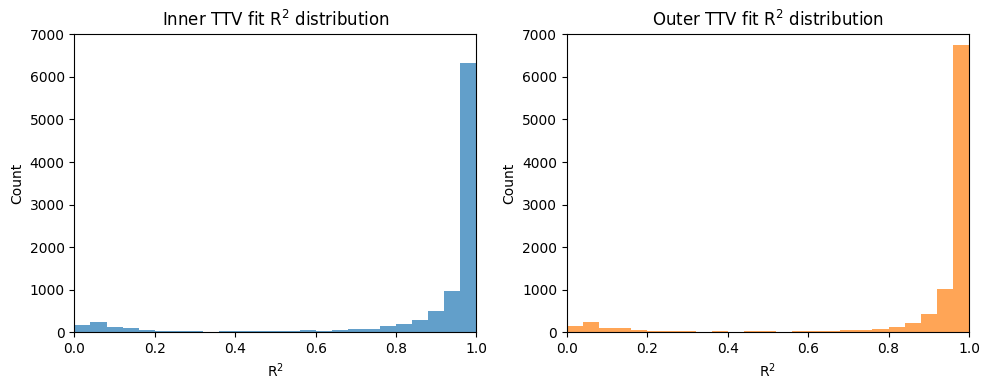

,e1,w1,e2,w2,Delta,j,P1,P2,m1,m2,...,phase1,std1,A2,B2,V2,Pttv2,phase2,std2,R2_1,R2_2
0,0.058306,335.782726,0.011494,310.698532,0.004305,2,7,14.060276,888.106499,5.811407,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.028485,246.203766,0.014750,25.279734,-0.000542,4,7,9.328275,1.670817,18.568077,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.033261,251.677774,0.010408,190.621447,-0.005616,3,7,10.441034,156.370505,3.220913,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.059741,13.834776,0.005490,208.731941,0.018480,3,7,10.694040,509.904128,45.917598,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.019589,173.367853,0.027752,133.406284,0.001706,4,7,9.349257,155.585324,143.615361,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
# Import CSV for fits
fits = pd.read_csv(r"C:\Users\WBS\Desktop\EXOPLANET WORK\006 NATSUME\validation\1st_order_TTVFast\lithwick_TTVFast_fits.csv")
total = len(fits)

# R2-score histograms
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].hist(fits['R2_1'], bins=25, color='C0', alpha=0.7, range=(0, 1))
ax[0].set_title('Inner TTV fit R$^2$ distribution')

ax[1].hist(fits['R2_2'], bins=25, color='C1', alpha=0.7, range=(0, 1))
ax[1].set_title('Outer TTV fit R$^2$ distribution')

for a in ax:
    a.set_xlabel('R$^2$'); a.set_ylabel('Count')
    a.set_ylim(0,7000); a.set_xlim(0,1)

plt.tight_layout()
plt.show()

fits.head()

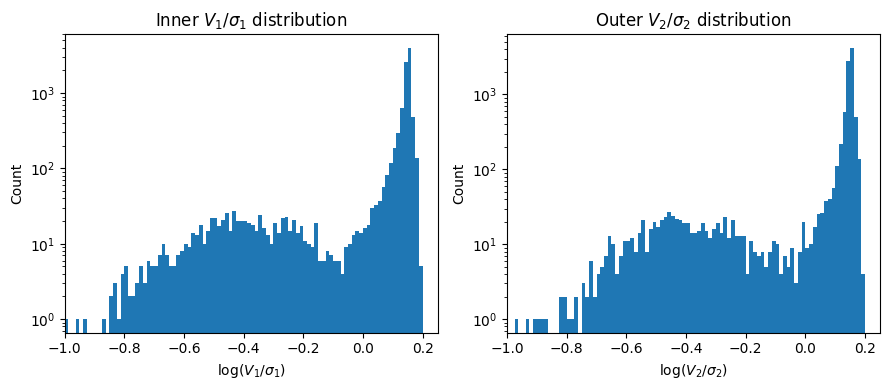

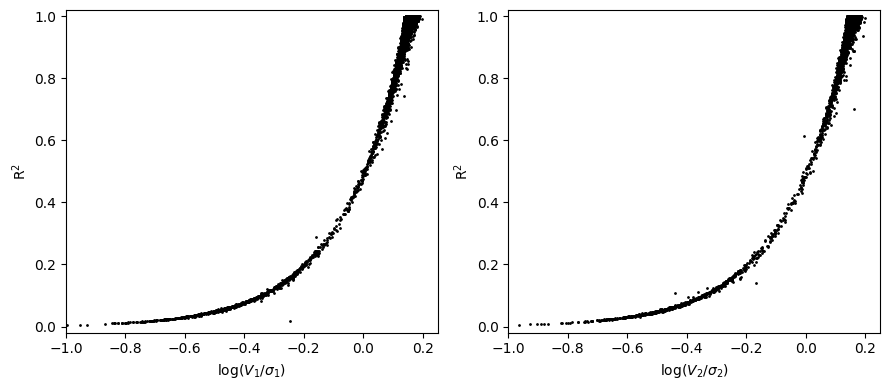

In [100]:
# Fit Amplitude / dispersion
amp_goodness1 = np.log10(np.abs(fits.V1) / fits.std1)
amp_goodness2 = np.log10(np.abs(fits.V2) / fits.std2)

# V/sigma histograms
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
rng = (-1, 0.25)
ax[0].hist(amp_goodness1, bins=100, range=rng)
ax[0].set_title('Inner $V_1/\sigma_1$ distribution')
ax[0].set_yscale('log')
ax[0].set_xlim(rng)

ax[1].hist(amp_goodness2, bins=100, range=rng)
ax[1].set_title('Outer $V_2/\sigma_2$ distribution')
ax[1].set_yscale('log')
ax[1].set_xlim(rng)

for i, a in enumerate(ax):
    a.set_xlabel(f'$\log(V_{i+1}/\sigma_{i+1})$'); a.set_ylabel('Count')

plt.tight_layout()
plt.show()

# V/sigma-R2 scatterplot
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

ax[0].scatter(amp_goodness1, fits.R2_1, s=1, color='black')
ax[0].set_xlim(rng), ax[0].set_ylim(-0.02,1.02)
ax[0].set_xlabel('$\log(V_1/\sigma_1)$'); ax[0].set_ylabel('R$^2$')

ax[1].scatter(amp_goodness2, fits.R2_2, s=1, color='black')
ax[1].set_xlim(rng), ax[1].set_ylim(-0.02,1.02)
ax[1].set_xlabel('$\log(V_2/\sigma_2)$'); ax[1].set_ylabel('R$^2$')

plt.tight_layout()
plt.show()

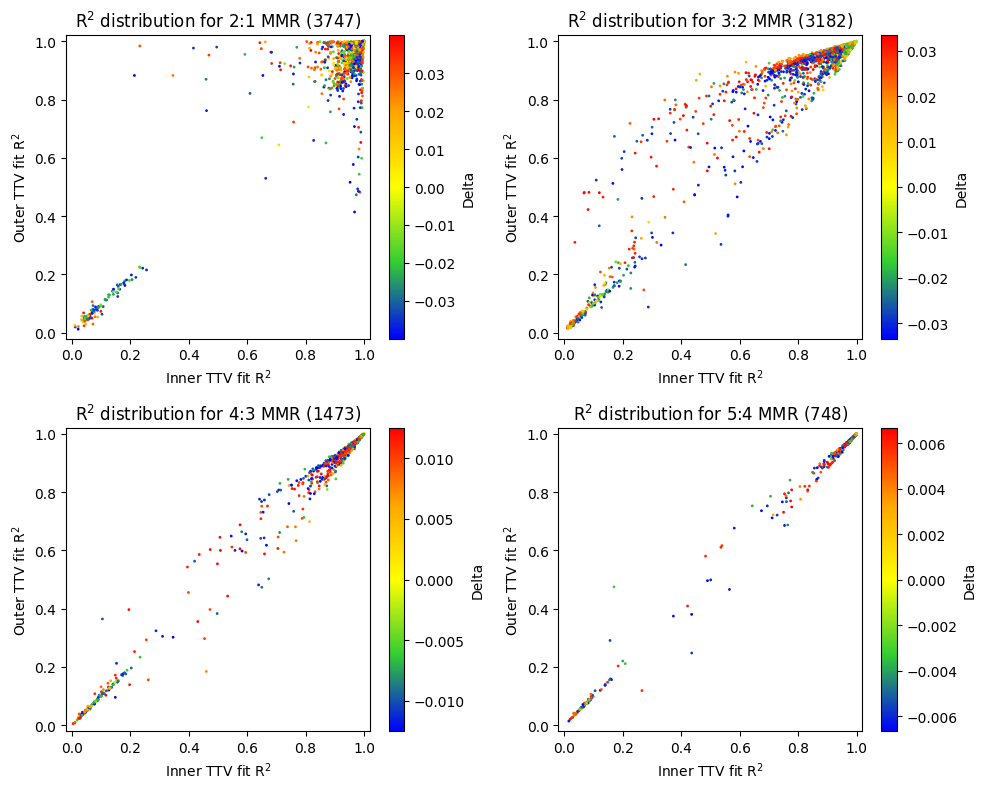

In [101]:
# R2-score scatterplots
fig, ax = plt.subplots(2, 2, figsize=(10,8))

for j, coords in zip(range(2,6), [(0,0),(0,1),(1,0),(1,1)]):
    ccol = 'Delta'  # Colormap column
    jmask = (fits.j == j) & (fits.valid == True)
    vmax = fits[ccol][jmask].max()
    vmin = fits[ccol][jmask].min()
    jtot = jmask.sum()

    # # Delta threshold filter (Kept in case for full range evaluation)
    # jtot = jmask.sum(); n=5
    # dmask = (fits.Delta > -vmax/n) & (fits.Delta < vmax/n)
    # jdtot = (jmask & dmask).sum()
    # print(f'Delta-filter remaining ({j}:{j-1}): {jdtot}/{jtot} ({jdtot/jtot*100:.2f}%)')
    
    # Create custom colormap: blue at vmin, yellow at 0, red at vmax
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    zero = (0 - vmin) / (vmax - vmin)
    colors = [
        (0.0, 'blue'),    # vmin
        ((0.0 + zero)/2, 'limegreen'),
        (zero, 'yellow'), # at 0
        ((1.0 + zero)/2, 'orange'),
        (1.0, 'red')      # vmax
    ]
    cmap = mcolors.LinearSegmentedColormap.from_list('custom', colors)
    
    sc = ax[coords].scatter(fits['R2_1'][jmask], fits['R2_2'][jmask], s=1,
                            c=fits[ccol][jmask], cmap=cmap)
    ax[coords].set_xlabel('Inner TTV fit R$^2$'); ax[coords].set_ylabel('Outer TTV fit R$^2$')
    ax[coords].set_xlim(-0.02,1.02); ax[coords].set_ylim(-0.02,1.02)
    ax[coords].set_title(f'R$^2$ distribution for {j}:{j-1} MMR ({jtot})')
    
    fig.colorbar(sc, ax=ax[coords], label='Delta')

plt.tight_layout()
plt.show()

In [102]:
# Filter by R2
# Minimum 10% percentile
p5_1 = np.nanpercentile(fits.R2_1, 10)
p5_2 = np.nanpercentile(fits.R2_2, 10)
print(f'Filter for R^2 (Inner TTV) and R^2 (Outer TTV): {p5_1}, {p5_2}')

R2_threshold = 0.5
R2_filter = (fits.R2_1 > p5_1) & (fits.R2_2 > p5_2)
fits = fits[R2_filter].reset_index()
good = len(fits)

print(f'Good systems: {good}/{total} ({(good/total) * 100:.2f}%)')

fits.head()

Filter for R^2 (Inner TTV) and R^2 (Outer TTV): 0.6500327772591751, 0.752740984564084
Good systems: 8402/40000 (21.00%)


,index,e1,w1,e2,w2,Delta,j,P1,P2,m1,...,phase1,std1,A2,B2,V2,Pttv2,phase2,std2,R2_1,R2_2
0,7,0.003121,340.131786,0.002949,308.013862,0.008316,3,7,10.587314,4.433311,...,1.153719,0.014154,0.000553,-1.832667e-06,0.004608,401.537187,4.185556,0.003318,0.982665,0.984181
1,10,0.006358,65.320823,0.037346,99.381557,0.039954,2,7,14.559354,299.838952,...,6.357639,0.014289,0.021919,-7.552084e-05,0.070511,208.646075,3.486028,0.049070,0.995985,0.996501
2,18,0.003447,351.971897,0.001103,278.012919,0.029967,2,7,14.419543,1.792868,...,5.695271,0.000238,-0.000008,2.937861e-08,0.000228,240.911797,2.551439,0.000159,0.996888,0.999388
3,19,0.001368,3.171139,0.002037,47.010804,-0.005361,5,7,8.703090,0.787491,...,5.395776,0.372034,0.000989,-2.953919e-06,0.018492,447.470253,2.253514,0.012488,0.985507,0.985139
4,24,0.001772,195.713847,0.005222,204.937923,0.009336,2,7,14.130700,4.070876,...,4.047305,0.001406,-0.000073,5.938602e-08,0.001640,759.729605,1.085839,0.001154,0.999482,0.999081


In [156]:
# Functions, returns in %
def relerr(calc, sol):
    nonan = ~np.isnan(calc) & ~np.isnan(sol) & (calc/sol < 1e+3) & (calc/sol > 1e-3) 
    relerrs = calc[nonan]/sol[nonan]
    return relerrs

def err_gmean(calc, sol):
    relerrs = relerr(calc, sol)
    gavg = gmean(relerrs)
    return gavg

def err_med(calc, sol):
    relerrs = relerr(calc, sol)
    med = np.median(relerrs)
    return med

def err_gstd(calc, sol):
    relerrs = relerr(calc, sol)    
    logs = np.log(relerrs)
    gstd = np.exp(logs.std(ddof=0))
    return gstd

def err_1sig_percentiles(calc, sol):
    relerrs = relerr(calc, sol)
    p16 = np.percentile(relerrs, 16)
    p84 = np.percentile(relerrs, 84)
    return p16, p84

def num2dex(x):
    return np.log10(x)

def returnMetrics(df, mask='all', mode='gstd'):
    if isinstance(mask, str):
        if (mask == 'all'):
            m = np.ones(len(df), dtype=bool)
    else:
        m = mask
        
    err1 = err_gmean(df['m_calc_in'][m], df['m1'][m])
    err2 = err_gmean(df['m_calc_out'][m], df['m2'][m])
    med1 = err_med(df['m_calc_in'][m], df['m1'][m])
    med2 = err_med(df['m_calc_out'][m], df['m2'][m])

    if mode == 'gstd':
        gstd1 = err_gstd(df['m_calc_in'][m], df['m1'][m])
        gstd2 = err_gstd(df['m_calc_out'][m], df['m2'][m])
    
        MetricArr = err1, err2, med1, med2, gstd1, gstd2
        MetricArr = num2dex(MetricArr)
        
    elif mode == 'percentile':
        p16_1, p84_1 = err_1sig_percentiles(df['m_calc_in'][m], df['m1'][m])
        p16_2, p84_2 = err_1sig_percentiles(df['m_calc_out'][m], df['m2'][m])

        MetricArr = err1, err2, med1, med2, p16_1, p84_1, p16_2, p84_2
        MetricArr = num2dex(MetricArr)
        
    return MetricArr

# Non-nominal validation

In [78]:
# Naive validation
valid = fits['valid']
j = fits['j']; mmr = j.apply(lambda x: f"{int(x)}:{int(x)-1}")
P_in = fits['P1']; P_out = fits['P2']
PTTV_in = fits['Pttv1']; PTTV_out = fits['Pttv2']
V_in = np.abs(fits['V1']); V_out = np.abs(fits['V2'])
Mstar = 1

e1 = fits['e1']; w1 = fits['w1']
e2 = fits['e2']; w2 = fits['w2']
z = [natsume.get_ComplexEccentricities(e1[i], w1[i], e2[i], w2[i]) for i in range(len(e1))]

mu_in_sol = (fits['m1'].values * M_earth).to(Mstar*u.M_sun).value
mu_out_sol = (fits['m2'].values * M_earth).to(Mstar*u.M_sun).value

# Extract mu_out and mu_in
mcalc_out, mcalc_in = np.array([]), np.array([])
mbad_out, mbad_in = np.array([]), np.array([])

for i in tqdm(range(len(mmr))):
    if valid[i] == False:  # If invalid column
        mcalc_in = np.append(mcalc_in, np.nan)
        mcalc_out = np.append(mcalc_out, np.nan)
        mbad_in = np.append(mbad_in, np.nan)
        mbad_out = np.append(mbad_out, np.nan)
        continue
    
    TTV_in = natsume.get_TTVSineCurve(amplitude=V_in[i], superperiod=PTTV_in[i])
    TTV_out = natsume.get_TTVSineCurve(amplitude=V_out[i], superperiod=PTTV_out[i])

    mu_in = natsume.EstimateInnerMass(outerTTV=TTV_out, outer_period=P_out[i], mmr=mmr[i], eccentricity=z[i])
    mu_out = natsume.EstimateOuterMass(innerTTV=TTV_in, inner_period=P_in[i], mmr=mmr[i], eccentricity=z[i])

    mu_in_expected = natsume.EstimateInnerMass(outerTTV=TTV_out, outer_period=P_out[i], mmr=mmr[i],
                                               eccentricity=z[i], inner_period=P_in[i])
    mu_out_expected = natsume.EstimateOuterMass(innerTTV=TTV_in, inner_period=P_in[i], mmr=mmr[i],
                                                eccentricity=z[i], outer_period=P_out[i])

    mu_in_closest = mu_in[np.argmin(np.abs(mu_in - mu_in_expected))]
    mu_out_closest =  mu_out[np.argmin(np.abs(mu_out - mu_out_expected))]    
    m_in = (mu_in_closest * Mstar*u.M_sun).to(u.M_earth).value
    m_out = (mu_out_closest * Mstar*u.M_sun).to(u.M_earth).value

    mcalc_in = np.append(mcalc_in, m_in)
    mcalc_out = np.append(mcalc_out, m_out)

    mu_in_bad = mu_in[np.argmax(np.abs(mu_in - mu_in_expected))]
    mu_out_bad =  mu_out[np.argmax(np.abs(mu_out - mu_out_expected))]    
    m_in_bad = (mu_in_bad * Mstar*u.M_sun).to(u.M_earth).value
    m_out_bad = (mu_out_bad * Mstar*u.M_sun).to(u.M_earth).value

    mbad_in = np.append(mbad_in, m_in_bad)
    mbad_out = np.append(mbad_out, m_out_bad)

compare = fits.copy()
compare['m_calc_in'] = mcalc_in
compare['m_calc_out'] = mcalc_out
compare['m_bad_in'] = mbad_in
compare['m_bad_out'] = mbad_out
compare.head()

100%|██████████████████████████████████████████████████████████████████████████████| 8402/8402 [01:48<00:00, 77.61it/s]


,index,e1,w1,e2,w2,Delta,j,P1,P2,m1,...,V2,Pttv2,phase2,std2,R2_1,R2_2,m_calc_in,m_calc_out,m_bad_in,m_bad_out
0,7,0.003121,340.131786,0.002949,308.013862,0.008316,3,7,10.587314,4.433311,...,0.004608,401.537187,4.185556,0.003318,0.982665,0.984181,4.389382,29.750822,5.070425,34.618684
1,10,0.006358,65.320823,0.037346,99.381557,0.039954,2,7,14.559354,299.838952,...,0.070511,208.646075,3.486028,0.049070,0.995985,0.996501,665.902309,146.286296,539.766809,124.425468
2,18,0.003447,351.971897,0.001103,278.012919,0.029967,2,7,14.419543,1.792868,...,0.000228,240.911797,2.551439,0.000159,0.996888,0.999388,1.763747,1.831281,3.536607,2.206796
3,19,0.001368,3.171139,0.002037,47.010804,-0.005361,5,7,8.703090,0.787491,...,0.018492,447.470253,2.253514,0.012488,0.985507,0.985139,9.957069,378.988336,8.679102,324.029979
4,24,0.001772,195.713847,0.005222,204.937923,0.009336,2,7,14.130700,4.070876,...,0.001640,759.729605,1.085839,0.001154,0.999482,0.999081,5.578111,3.799059,5.090401,3.601615


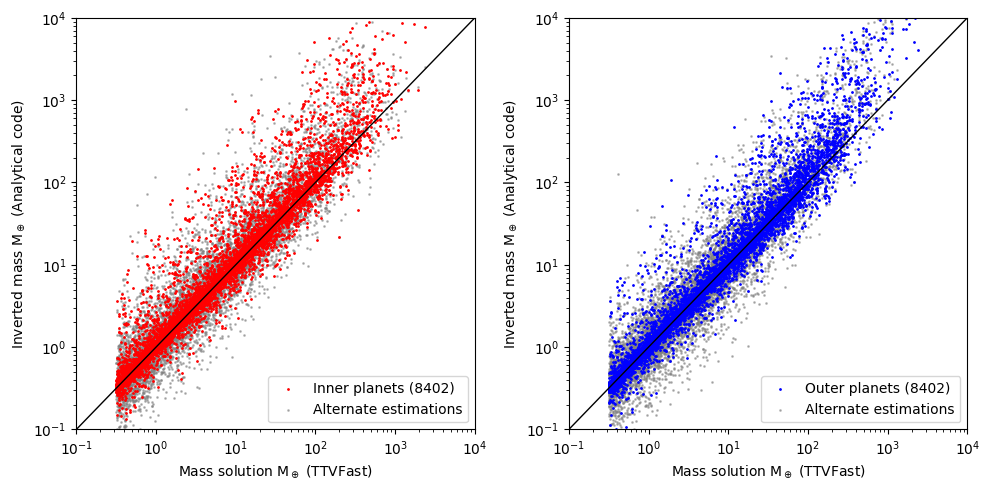

In [136]:
# Graph compare N-body outputs
fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
s = 1
minval = 1e-1
maxval = 1e+4
scatterCount = len(compare['m1'])

# Inner planets
ax[0].scatter(compare['m1'], compare['m_calc_in'], s=s, color='red', label=f'Inner planets ({scatterCount})', zorder=0)
ax[0].scatter(compare['m1'], compare['m_bad_in'], s=s, color='grey', label='Alternate estimations', zorder=-1, alpha=0.5)
ax[0].plot([minval, maxval], [minval, maxval], color='black', lw=1, zorder=1)
ax[0].set_xscale('log'); ax[0].set_yscale('log')
ax[0].set_xlim(minval, maxval); ax[0].set_ylim(minval, maxval)
ax[0].set_xlabel('Mass solution M$_\oplus$ (TTVFast)')
ax[0].set_ylabel('Inverted mass M$_\oplus$ (Analytical code)')
ax[0].legend(loc='lower right')

# Outer planets
ax[1].scatter(compare['m2'], compare['m_calc_out'], s=s, color='blue', label=f'Outer planets ({scatterCount})', zorder=0)
ax[1].scatter(compare['m2'], compare['m_bad_out'], s=s, color='grey', label='Alternate estimations', zorder=-1, alpha=0.5)
ax[1].plot([minval, maxval], [minval, maxval], color='black', lw=1, zorder=1)
ax[1].set_xscale('log'); ax[1].set_yscale('log')
ax[1].set_xlim(minval, maxval); ax[1].set_ylim(minval, maxval)
ax[1].set_xlabel('Mass solution M$_\oplus$ (TTVFast)')
ax[1].set_ylabel('Inverted mass M$_\oplus$ (Analytical code)')
ax[1].legend(loc='lower right')

fig.tight_layout()
plt.show()

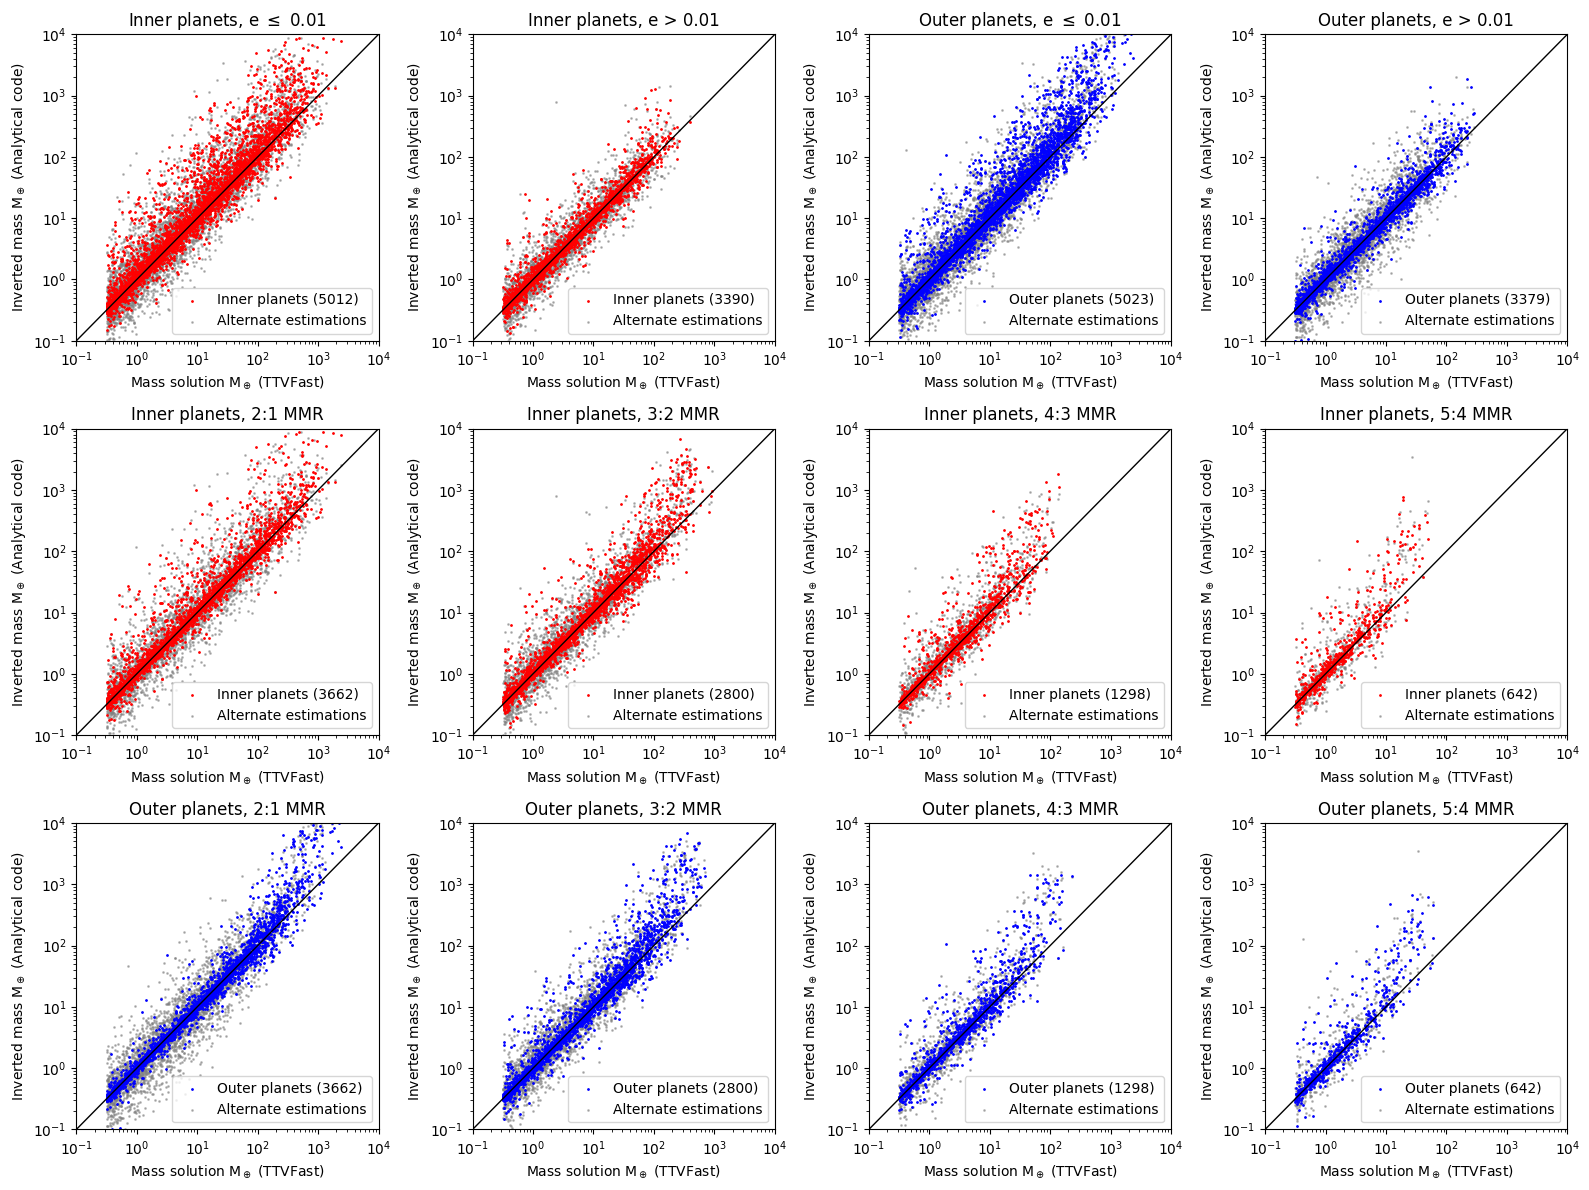

In [137]:
# Divide up by eccentricity and MMR
# Graph compare N-body outputs
fig, ax = plt.subplots(3, 4, figsize=(16, 12))

def plotMassEstimation(posTuple, x, ygood, ybad, color, innerouterStr, mask, regimeName):
    s = 1
    minval = 1e-1
    maxval = 1e+4
    scatterCount = len(x[mask])
    
    ax[posTuple].scatter(x[mask], ygood[mask], s=s, color=color, label=f'{innerouterStr} planets ({scatterCount})', zorder=0)
    ax[posTuple].scatter(x[mask], ybad[mask], s=s, color='grey', label='Alternate estimations', zorder=-1, alpha=0.5)
    ax[posTuple].plot([minval, maxval], [minval, maxval], color='black', lw=1, zorder=1)
    ax[posTuple].set_xscale('log'); ax[posTuple].set_yscale('log')
    ax[posTuple].set_xlim(minval, maxval); ax[posTuple].set_ylim(minval, maxval)
    ax[posTuple].set_xlabel('Mass solution M$_\oplus$ (TTVFast)')
    ax[posTuple].set_ylabel('Inverted mass M$_\oplus$ (Analytical code)')
    ax[posTuple].legend(loc='lower right')
    ax[posTuple].set_title(f'{innerouterStr} planets, {regimeName}')

def plotMassWithRegimes(df):
    # Regime definitions
    ethres = 0.01
    lowe1 = (compare.e1 <= ethres); highe1 = (compare.e1 > ethres)
    lowe2 = (compare.e2 <= ethres); highe2 = (compare.e2 > ethres)
    def jmask(n): 
        return (compare.j == n)
    
    # Eccentricity
    plotMassEstimation((0,0), df['m1'], df['m_calc_in'], df['m_bad_in'], 'red', 'Inner', lowe1, 'e $\leq$ 0.01')
    plotMassEstimation((0,1), df['m1'], df['m_calc_in'], df['m_bad_in'], 'red', 'Inner', highe1, 'e > 0.01')
    plotMassEstimation((0,2), df['m2'], df['m_calc_out'], df['m_bad_out'], 'blue', 'Outer', lowe2, 'e $\leq$ 0.01')
    plotMassEstimation((0,3), df['m2'], df['m_calc_out'], df['m_bad_out'], 'blue', 'Outer', highe2, 'e > 0.01')
    
    # MMR
    plotMassEstimation((1,0), df['m1'], df['m_calc_in'], df['m_bad_in'], 'red', 'Inner', jmask(2), '2:1 MMR')
    plotMassEstimation((1,1), df['m1'], df['m_calc_in'], df['m_bad_in'], 'red', 'Inner', jmask(3), '3:2 MMR')
    plotMassEstimation((1,2), df['m1'], df['m_calc_in'], df['m_bad_in'], 'red', 'Inner', jmask(4), '4:3 MMR')
    plotMassEstimation((1,3), df['m1'], df['m_calc_in'], df['m_bad_in'], 'red', 'Inner', jmask(5), '5:4 MMR')
    
    plotMassEstimation((2,0), df['m2'], df['m_calc_out'], df['m_bad_out'], 'blue', 'Outer', jmask(2), '2:1 MMR')
    plotMassEstimation((2,1), df['m2'], df['m_calc_out'], df['m_bad_out'], 'blue', 'Outer', jmask(3), '3:2 MMR')
    plotMassEstimation((2,2), df['m2'], df['m_calc_out'], df['m_bad_out'], 'blue', 'Outer', jmask(4), '4:3 MMR')
    plotMassEstimation((2,3), df['m2'], df['m_calc_out'], df['m_bad_out'], 'blue', 'Outer', jmask(5), '5:4 MMR')

plotMassWithRegimes(compare)

fig.tight_layout()
plt.show()

In [157]:
# Relative bias and average error
err1, err2, med1, med2, gstd1, gstd2 = returnMetrics(compare, mask='all')

print(f'Geometric mean error, median error, and geometric STD (Inner): {err1:.3f} dex, {med1:.3f} dex, {gstd1:.3f} dex')
print(f'Geometric mean error, median error, and geometric STD (Outer): {err2:.3f} dex, {med2:.3f} dex, {gstd2:.3f} dex')

Geometric mean error, median error, and geometric STD (Inner): 0.082 dex, 0.022 dex, 0.251 dex
Geometric mean error, median error, and geometric STD (Outer): 0.069 dex, 0.017 dex, 0.232 dex


# Nominal validation

In [85]:
# Naive nominal mass validation
j = fits['j']; mmr = j.apply(lambda x: f"{int(x)}:{int(x)-1}")
P_in = fits['P1']; P_out = fits['P2']
PTTV_in = fits['Pttv1']; PTTV_out = fits['Pttv2']
V_in = np.abs(fits['V1']); V_out = np.abs(fits['V2'])
Mstar = 1

e1 = fits['e1']; w1 = fits['w1']
e2 = fits['e2']; w2 = fits['w2']
z = [natsume.get_ComplexEccentricities() for i in range(len(e1))]

mu_in_sol = (fits['m1'].values * M_earth).to(Mstar*u.M_sun).value
mu_out_sol = (fits['m2'].values * M_earth).to(Mstar*u.M_sun).value

# Extract mu_out and mu_in
mcalc_out, mcalc_in = np.array([]), np.array([])
mbad_out, mbad_in = np.array([]), np.array([])
for i in tqdm(range(len(mmr))):
    if valid[i] == False:  # If invalid column
        mcalc_in = np.append(mcalc_in, np.nan)
        mcalc_out = np.append(mcalc_out, np.nan)
        mbad_in = np.append(mbad_in, np.nan)
        mbad_out = np.append(mbad_out, np.nan)
        continue
    
    TTV_in = natsume.get_TTVSineCurve(amplitude=V_in[i], superperiod=PTTV_in[i])
    TTV_out = natsume.get_TTVSineCurve(amplitude=V_out[i], superperiod=PTTV_out[i])

    mu_in = natsume.EstimateInnerMass(outerTTV=TTV_out, outer_period=P_out[i], mmr=mmr[i], eccentricity=z[i])
    mu_out = natsume.EstimateOuterMass(innerTTV=TTV_in, inner_period=P_in[i], mmr=mmr[i], eccentricity=z[i])

    mu_in_expected = natsume.EstimateInnerMass(outerTTV=TTV_out, outer_period=P_out[i], mmr=mmr[i],
                                               eccentricity=z[i], inner_period=P_in[i])
    mu_out_expected = natsume.EstimateOuterMass(innerTTV=TTV_in, inner_period=P_in[i], mmr=mmr[i],
                                                eccentricity=z[i], outer_period=P_out[i])

    mu_in_closest = mu_in[np.argmin(np.abs(mu_in - mu_in_expected))]
    mu_out_closest =  mu_out[np.argmin(np.abs(mu_out - mu_out_expected))]    
    m_in = (mu_in_closest * Mstar*u.M_sun).to(u.M_earth).value
    m_out = (mu_out_closest * Mstar*u.M_sun).to(u.M_earth).value

    mcalc_in = np.append(mcalc_in, m_in)
    mcalc_out = np.append(mcalc_out, m_out)

    mu_in_bad = mu_in[np.argmax(np.abs(mu_in - mu_in_expected))]
    mu_out_bad =  mu_out[np.argmax(np.abs(mu_out - mu_out_expected))]    
    m_in_bad = (mu_in_bad * Mstar*u.M_sun).to(u.M_earth).value
    m_out_bad = (mu_out_bad * Mstar*u.M_sun).to(u.M_earth).value

    mbad_in = np.append(mbad_in, m_in_bad)
    mbad_out = np.append(mbad_out, m_out_bad)

compare_n = fits.copy()
compare_n['m_calc_in'] = mcalc_in
compare_n['m_calc_out'] = mcalc_out
compare_n['m_bad_in'] = mbad_in
compare_n['m_bad_out'] = mbad_out
compare_n.head()

100%|██████████████████████████████████████████████████████████████████████████████| 8402/8402 [01:51<00:00, 75.34it/s]


,index,e1,w1,e2,w2,Delta,j,P1,P2,m1,...,V2,Pttv2,phase2,std2,R2_1,R2_2,m_calc_in,m_calc_out,m_bad_in,m_bad_out
0,7,0.003121,340.131786,0.002949,308.013862,0.008316,3,7,10.587314,4.433311,...,0.004608,401.537187,4.185556,0.003318,0.982665,0.984181,4.729640,32.112831,4.934586,34.485401
1,10,0.006358,65.320823,0.037346,99.381557,0.039954,2,7,14.559354,299.838952,...,0.070511,208.646075,3.486028,0.049070,0.995985,0.996501,976.538063,153.108214,703.185426,126.612577
2,18,0.003447,351.971897,0.001103,278.012919,0.029967,2,7,14.419543,1.792868,...,0.000228,240.911797,2.551439,0.000159,0.996888,0.999388,2.667792,2.139949,2.013376,1.813694
3,19,0.001368,3.171139,0.002037,47.010804,-0.005361,5,7,8.703090,0.787491,...,0.018492,447.470253,2.253514,0.012488,0.985507,0.985139,10.785680,420.531637,10.385124,399.648986
4,24,0.001772,195.713847,0.005222,204.937923,0.009336,2,7,14.130700,4.070876,...,0.001640,759.729605,1.085839,0.001154,0.999482,0.999081,5.509021,3.774615,5.048636,3.581851


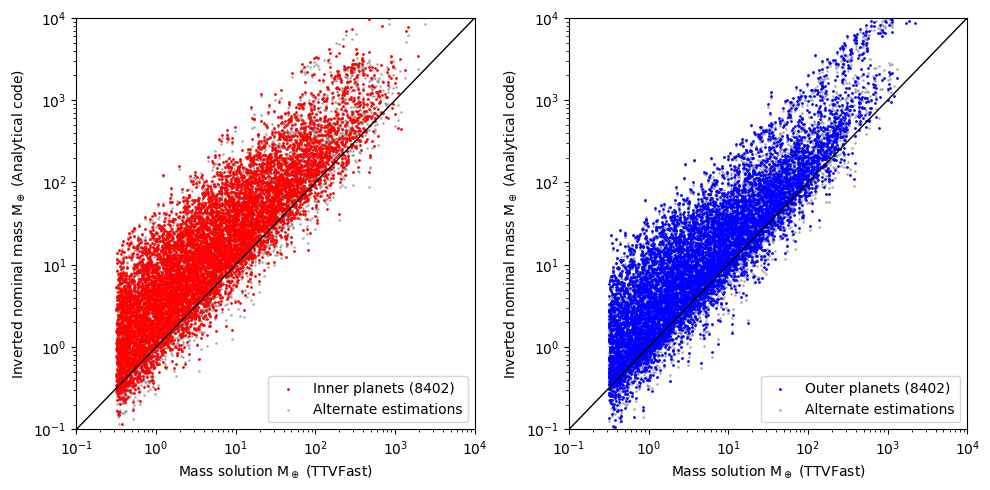

In [87]:
# Graph compare N-body outputs
fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
s = 1
minval = 1e-1
maxval = 1e+4

scatterCount = len(compare_n['m1'])

# Inner planets
ax[0].scatter(compare_n['m1'], compare_n['m_calc_in'], s=s, color='red', label=f'Inner planets ({scatterCount})', zorder=0)
ax[0].scatter(compare_n['m1'], compare_n['m_bad_in'], s=s, color='grey', label='Alternate estimations', zorder=-1, alpha=0.5)
ax[0].plot([minval, maxval], [minval, maxval], color='black', lw=1, zorder=1)
ax[0].set_xscale('log'); ax[0].set_yscale('log')
ax[0].set_xlim(minval, maxval); ax[0].set_ylim(minval, maxval)
ax[0].set_xlabel('Mass solution M$_\oplus$ (TTVFast)')
ax[0].set_ylabel('Inverted nominal mass M$_\oplus$ (Analytical code)')
ax[0].legend(loc='lower right')

# Outer planets
ax[1].scatter(compare_n['m2'], compare_n['m_calc_out'], s=s, color='blue', label=f'Outer planets ({scatterCount})', zorder=0)
ax[1].scatter(compare_n['m2'], compare_n['m_bad_out'], s=s, color='grey', label='Alternate estimations', zorder=-1, alpha=0.5)
ax[1].plot([minval, maxval], [minval, maxval], color='black', lw=1, zorder=1)
ax[1].set_xscale('log'); ax[1].set_yscale('log')
ax[1].set_xlim(minval, maxval); ax[1].set_ylim(minval, maxval)
ax[1].set_xlabel('Mass solution M$_\oplus$ (TTVFast)')
ax[1].set_ylabel('Inverted nominal mass M$_\oplus$ (Analytical code)')
ax[1].legend(loc='lower right')

fig.tight_layout()
plt.show()

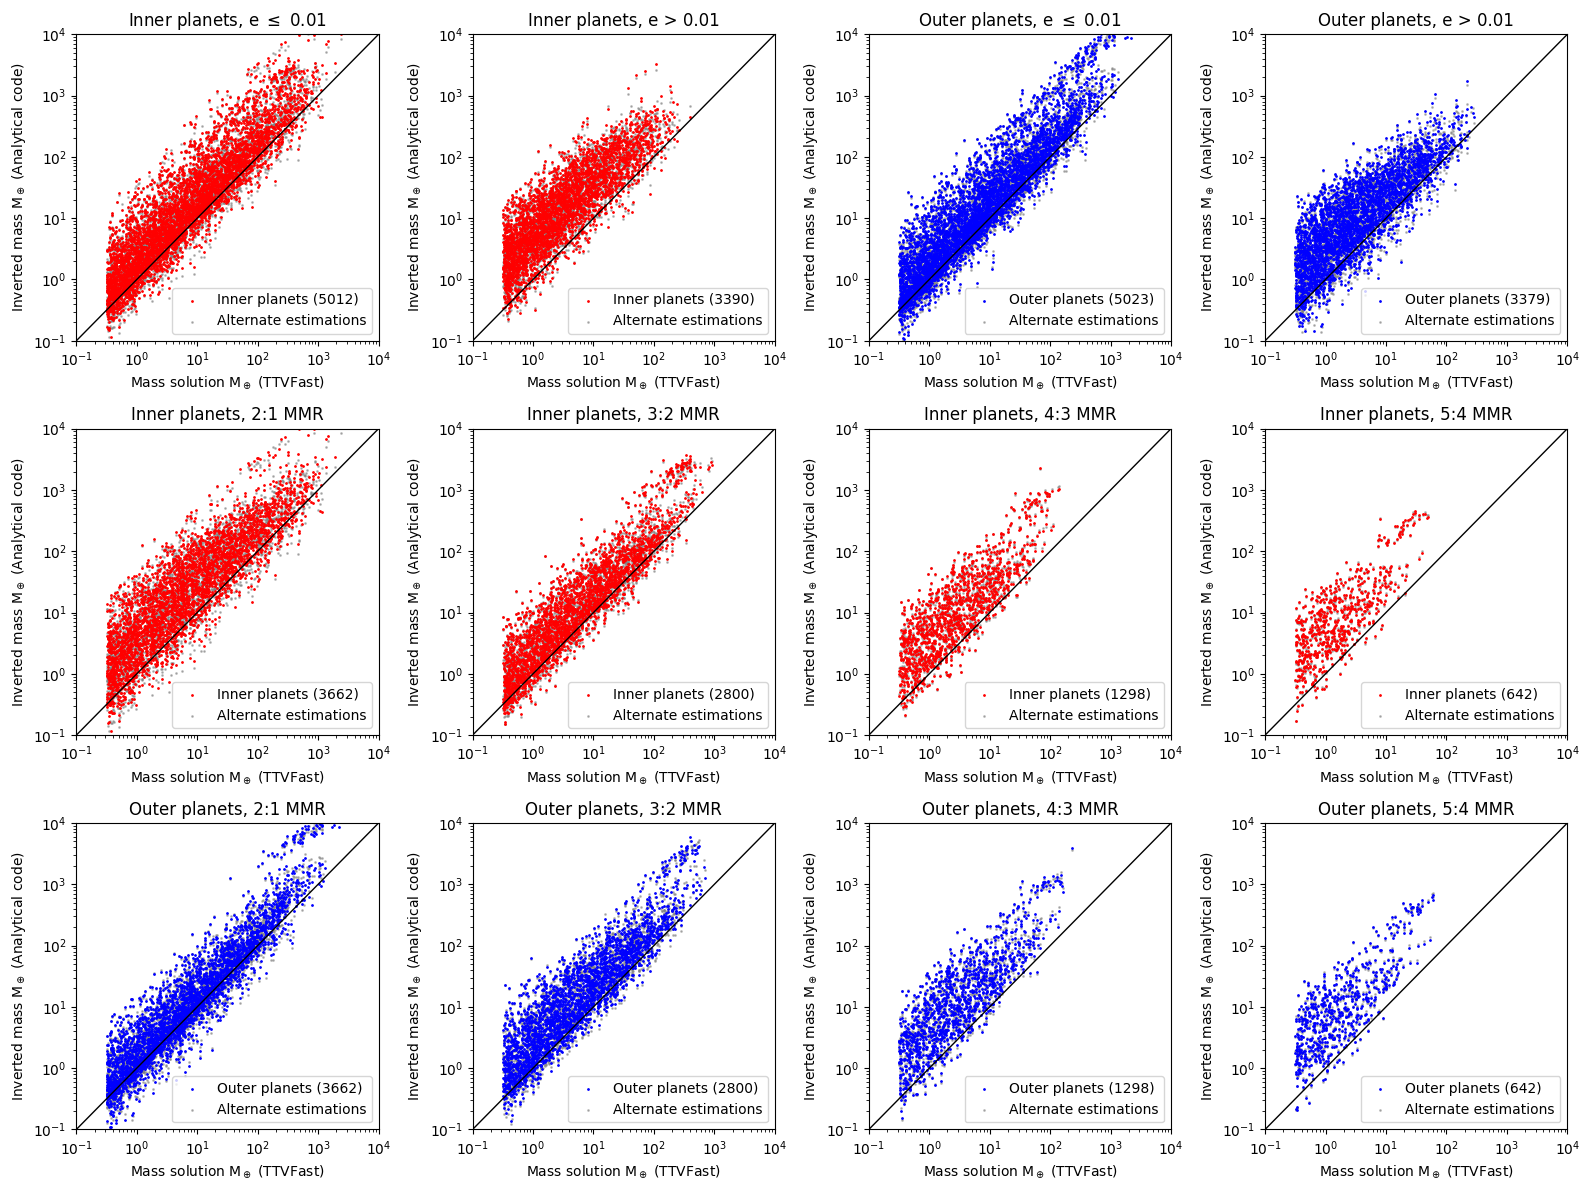

In [88]:
# Divide by regimes
fig, ax = plt.subplots(3, 4, figsize=(16, 12))
plotMassWithRegimes(compare_n)
fig.tight_layout()
plt.show()

In [143]:
# Relative bias and average error
err1, err2, med1, med2, gstd1, gstd2 = returnMetrics(compare_n, mask='all')

print(f'Geometric mean error, median error, and geometric STD (Inner): {err1:.3f} dex, {med1:.3f} dex, {gstd1:.3f} dex')
print(f'Geometric mean error, median error, and geometric STD (Outer): {err2:.3f} dex, {med2:.3f} dex, {gstd2:.3f} dex')

Geometric mean error, median error, and geometric STD (Inner): 0.475 dex, 0.430 dex, 0.413 dex
Geometric mean error, median error, and geometric STD (Outer): 0.378 dex, 0.309 dex, 0.399 dex


# Metric compilation

In [158]:
# Metric summarized in dataframe
metricCols = ['regime', 'count', 'GMerr', 'GMerr_n', 'MedErr', 'MedErr_n', 'p16Err', 'p16Err_n', 'p84Err', 'p84Err_n']
metrics = pd.DataFrame(columns=metricCols)
metrics.regime = ['Inner (Overall)', 'Inner (e = 0.001-0.01)', 'Inner (e = 0.01-0.1)',
                  'Inner (2:1 MMR)', 'Inner (3:2 MMR)', 'Inner (4:3 MMR)', 'Inner (5:4 MMR)',
                  'Outer (Overall)', 'Outer (e = 0.001-0.01)', 'Outer (e = 0.01-0.1)',
                  'Outer (2:1 MMR)', 'Outer (3:2 MMR)', 'Outer (4:3 MMR)', 'Outer (5:4 MMR)']
metrics.head()

,regime,count,GMerr,GMerr_n,MedErr,MedErr_n,p16Err,p16Err_n,p84Err,p84Err_n
0,Inner (Overall),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Inner (e = 0.001-0.01),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Inner (e = 0.01-0.1),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Inner (2:1 MMR),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Inner (3:2 MMR),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [159]:
# Regime definitions
ethres = 0.01
lowe1 = (compare.e1 <= ethres); highe1 = (compare.e1 > ethres)
lowe2 = (compare.e2 <= ethres); highe2 = (compare.e2 > ethres)
def jmask(n): 
    return (compare.j == n)

# Create values to insert
def createListToInsert(innerOuterStr, m):
    err1, err2, med1, med2, p16_1, p84_1, p16_2, p84_2 = returnMetrics(compare, mask=m, mode='percentile')
    err1n, err2n, med1n, med2n, p16_1n, p84_1n, p16_2n, p84_2n = returnMetrics(compare_n, mask=m, mode='percentile')

    if innerOuterStr == 'Inner':
        metrics = [err1, err1n, med1, med1n, p16_1, p16_1n, p84_1, p84_1n]
    elif innerOuterStr == 'Outer':
        metrics = [err2, err2n, med2, med2n, p16_2, p16_2n, p84_2, p84_2n]

    count = len(compare.m1) if (isinstance(m, str) == True) else len(compare.m1[m])
    return [count, *metrics]

rows = []
for io in ['Inner', 'Outer']:
    for regime in ['all', 'lowe', 'highe', *[jmask(n) for n in range(2,6)]]:
        r = regime
        if isinstance(r, str):
            r = lowe1 if (regime == 'lowe') and (io == 'Inner') else r
            r = lowe2 if (regime == 'lowe') and (io == 'Outer') else r
            r = highe1 if (regime == 'highe') and (io == 'Inner') else r
            r = highe2 if (regime == 'highe') and (io == 'Outer') else r
        rowi = createListToInsert(io, m=r)
        rows.append(rowi)

# Inserting time
for i, r in enumerate(rows):
    metrics.loc[i, metricCols[1:]] = r

metrics

,regime,count,GMerr,GMerr_n,MedErr,MedErr_n,p16Err,p16Err_n,p84Err,p84Err_n
0,Inner (Overall),8402,0.081755,0.474565,0.021944,0.430326,-0.046592,0.062483,0.184825,0.915606
1,Inner (e = 0.001-0.01),5012,0.117036,0.351857,0.031825,0.283481,-0.053944,0.005036,0.287216,0.740154
2,Inner (e = 0.01-0.1),3390,0.030011,0.65453,0.013815,0.649874,-0.039169,0.263746,0.080104,1.052436
3,Inner (2:1 MMR),3662,0.079525,0.509419,0.019791,0.485953,-0.040187,0.064517,0.160226,0.964696
4,Inner (3:2 MMR),2800,0.07233,0.344557,0.021496,0.285125,-0.05622,0.019959,0.184825,0.724333
5,Inner (4:3 MMR),1298,0.089246,0.555365,0.024573,0.519045,-0.04199,0.143352,0.210827,0.98912
6,Inner (5:4 MMR),642,0.120208,0.681621,0.033977,0.649325,-0.053879,0.280583,0.285455,1.121019
7,Outer (Overall),8402,0.068565,0.378081,0.016851,0.309427,-0.046555,0.004024,0.156534,0.812062
8,Outer (e = 0.001-0.01),5023,0.098197,0.321807,0.021471,0.242301,-0.04696,-0.01343,0.237342,0.715369
9,Outer (e = 0.01-0.1),3379,0.024758,0.461274,0.011898,0.426159,-0.04609,0.053557,0.076018,0.892743


In [160]:
# Export metrics
metrics.to_csv('lithwick_code_metrics.csv', index=False)

In [227]:
# Plot visualization
inner = metrics[0:7]; outer = metrics[7:14]

def metricPlots(df, innerOuterStr):
    regimenames = ['Overall', 'Low e', 'High e', '2:1', '3:2', '4:3', '5:4']
    colnames = ['Regime', 'Count', 'Geometric Mean Error [dex]', 'Geometric Mean Error (Nominal) [dex]',
                'Median Error [dex]', 'Median Error (Nominal) [dex]',
                'Error at 16th Percentile [dex]', 'Error at 16th Percentile (Nominal) [dex]',
                'Error at 84th Percentile [dex]', 'Error at 84th Percentile (Nominal) [dex]']

    yerr_lower = df.MedErr - df.p16Err; yerr_upper = df.p84Err - df.MedErr
    yerr = [yerr_lower, yerr_upper]
    
    yerrn_lower = df.MedErr_n - df.p16Err_n; yerrn_upper = df.p84Err_n - df.MedErr_n
    yerrn = [yerrn_lower, yerrn_upper]
    
    fig, ax = plt.subplots(1, 2, figsize=(11, 4))
    ax[0].errorbar(x=regimenames, y=df.MedErr, yerr=yerr, fmt='D', linestyle='none', color='black')
    ax[0].set_title('Fractional Error by Regime')
    ax[1].errorbar(x=regimenames, y=df.MedErr_n, yerr=yerrn, fmt='D', linestyle='none', color='black')
    ax[1].set_title('Fractional Error by Regime (Nomimal)')

    for i in range(7):
        ax[0].text(regimenames[i], df.p84Err[i]*1.02, f'{df.MedErr[i]:.3f}$^+{df.p84Err[i]:.3f}$$_-{df.p16Err[i]:.3f}$', ha='center', va='bottom')
    
    for a in ax:
        a.axhline(0, color='black', linestyle='--', linewidth=1)
        a.set_ylabel(f'Fractional error [dex]')
        a.set_xlabel(f'Regime ({innerOuterStr} planets)')

    plt.show()

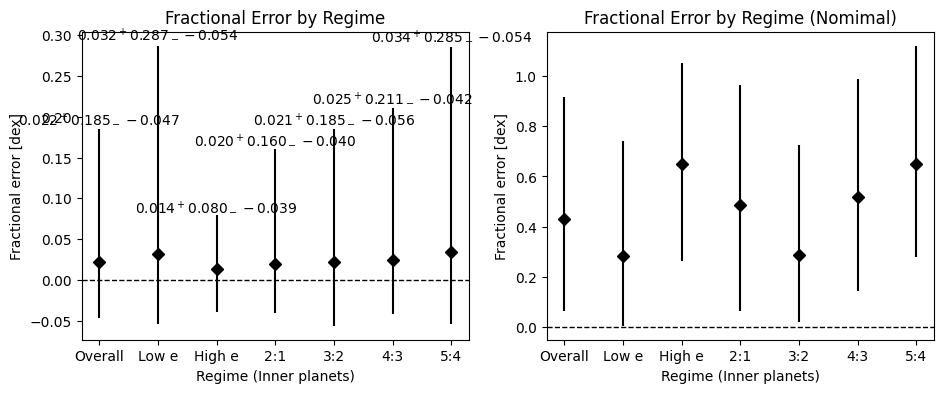

In [228]:
metricPlots(inner, 'Inner')

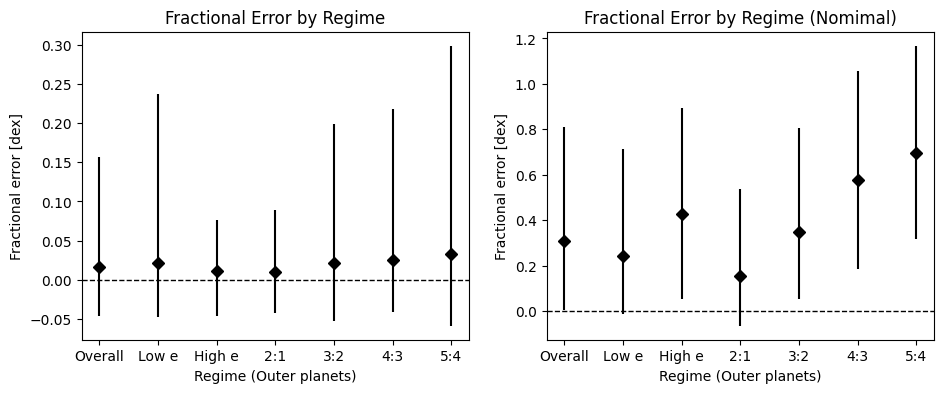

In [200]:
metricPlots(outer, 'Outer')